In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
from joblib import Parallel, delayed
import desispec.io
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0,'../py')
import sky

### Setup test data

In [3]:
everest_path = Path("/global/cfs/cdirs/desi/spectro/redux/everest/")
tile_path = everest_path / "tiles/"
hpx_path = everest_path / "healpix"
exp_path = everest_path / "exposures"

sample_data_cum = tile_path / "cumulative/80607/20201219/coadd-1-80607-thru20201219.fits"
sample_data_hpx = hpx_path / "main/dark/100/10000/coadd-main-dark-10000.fits"

In [4]:
cum_spec = desispec.io.read_spectra(sample_data_cum)
spectra = cum_spec.select(targets=[39633314146947827, 39633317665965689])
# hpx_spec = desispec.io.read_spectra(sample_data_hpx)

INFO:spectra.py:285:read_spectra: iotime 0.746 sec to read coadd-1-80607-thru20201219.fits at 2022-01-26T08:54:01.561554


# Prototype core algorithm of the function

In [5]:
def _preprocess_sky_frame(night, exp, petal, fiber, camera, **kwargs):
    exp_path = base_path / data_release / "exposures" / str(night) / str(exp).zfill(8)    
    sky_path = exp_path / f"sky-{camera}{petal}-{str(exp).zfill(8)}.fits"
    calib_path = exp_path / f"fluxcalib-{camera}{petal}-{str(exp).zfill(8)}.fits"
    cframe_path = exp_path /  f"cframe-{camera}{petal}-{str(exp).zfill(8)}.fits"

    sky_data = desispec.io.read_sky(str(sky_path))
    sky_data.fibermap = None # Need to set this for flux calibration function to work
    calib_data = desispec.io.read_flux_calibration(str(calib_path))
    cframe_data = desispec.io.read_frame(str(cframe_path), skip_resolution=True)

    sky_idx = fiber%500 #find the array idx of the fiber

    # The following uses a for loop internally for a part.
    # To reduce compute we may want to select specific objects here rather than calibratng the whole
    desispec.fluxcalibration.apply_flux_calibration(sky_data, calib_data) # modifies sky_data.flux and sky_data.ivar

    exp_sky_flux = sky_data.flux[sky_idx]
    exp_ivar = cframe_data.ivar[sky_idx]
    exp_sky_mask = np.logical_and(sky_data.mask[sky_idx], cframe_data.mask[sky_idx])
        

    return exp_sky_flux, exp_ivar, exp_sky_mask

In [6]:
data_release = "everest"

exp_fibermap = spectra.exp_fibermap
fibermap = spectra.fibermap

base_path = Path("/global/cfs/cdirs/desi/spectro/redux/")

sky_flux = {"b":[], "r":[], "z":[]}
sky_mask = {"b":[], "r":[], "z":[]}

for target in fibermap["TARGETID"]:
    target_table = exp_fibermap[exp_fibermap["TARGETID"]==target]
    # tgt_sky_flux = {"b":[], "r":[], "z":[]}
    # tgt_ivar = {"b":[], "r":[], "z":[]}
    # tgt_sky_mask = {"b":[], "r":[], "z":[]}
    
    for camera in ["b", "r", "z"]:
        exp_sky_flux, exp_ivar, exp_sky_mask = zip(
            *Parallel(n_jobs=15)(
                delayed(_preprocess_sky_frame)(night, exp, petal, fiber, camera)
                for night, exp, petal, fiber in zip(
                    target_table["NIGHT"],
                    target_table["EXPID"],
                    target_table["PETAL_LOC"],
                    target_table["FIBER"],
                )
            )
        )
        exp_sky_flux = np.array(exp_sky_flux)
        exp_ivar = np.array(exp_ivar)
        exp_sky_mask = np.array(exp_sky_mask)
    #     tgt_sky_flux[camera].append(exp_sky_flux[camera])
    #     tgt_ivar[camera].append(exp_ivar[camera])
    #     tgt_sky_mask[camera].append(1*exp_sky_mask[camera])
    # for camera in sky_flux:
    #     tgt_sky_flux[camera] = np.array(tgt_sky_flux[camera])
    #     tgt_ivar[camera] = np.array(tgt_ivar[camera])
        sky_flux[camera].append( np.sum(exp_sky_flux*exp_ivar, axis=0)/np.sum(exp_ivar, axis=0))
        sky_mask[camera].append(1*np.all(exp_sky_mask, axis=0))
for camera in sky_flux:
    sky_flux[camera] = np.array(sky_flux[camera])
    sky_mask[camera] = np.array(sky_mask[camera])
    

### Test the function

In [7]:
from sky import get_sky

path_to_spectra = '/global/cfs/cdirs/desi/spectro/redux/everest/tiles/cumulative/80607/20201219/coadd-1-80607-thru20201219.fits'
spectra = desispec.io.read_spectra(path_to_spectra)
spectra = cum_spec.select(targets=[39633314146947827, 39633317665965689])


sky_flux, sky_mask = get_sky(spectra)

INFO:spectra.py:285:read_spectra: iotime 0.734 sec to read coadd-1-80607-thru20201219.fits at 2022-01-26T08:55:29.007290


INFO:desiutil.log.dlm58.info:iotime 0.734 sec to read coadd-1-80607-thru20201219.fits at 2022-01-26T08:55:29.007290


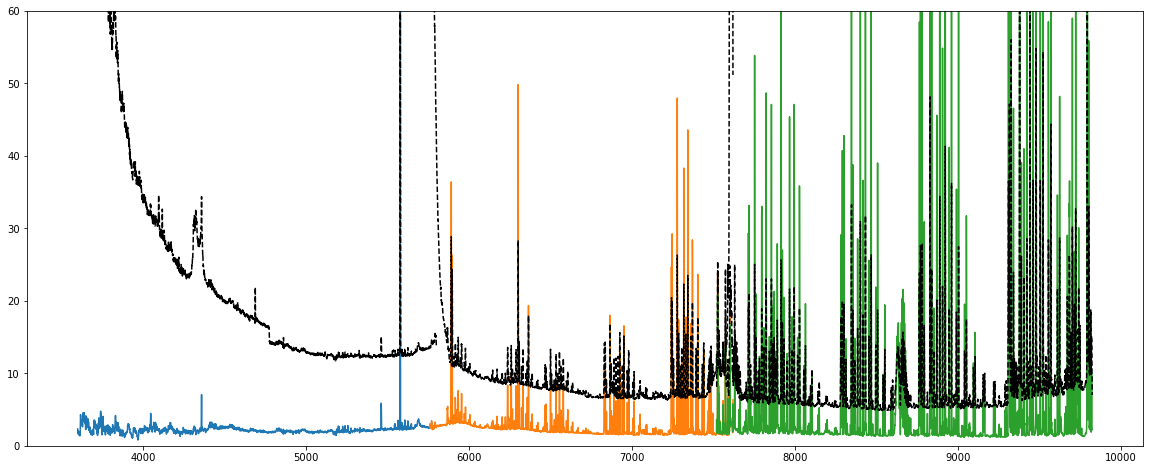

In [8]:
spectra_idx = 1

plt.figure(figsize=(20,8))
for camera in sky_flux:
    plt.plot(spectra.wave[camera],sky_flux[camera][spectra_idx])
    plt.plot(spectra.wave[camera],100 *(1/np.sqrt(spectra.ivar[camera][spectra_idx])), c="k", ls="--")
plt.ylim(0,60)
plt.show()

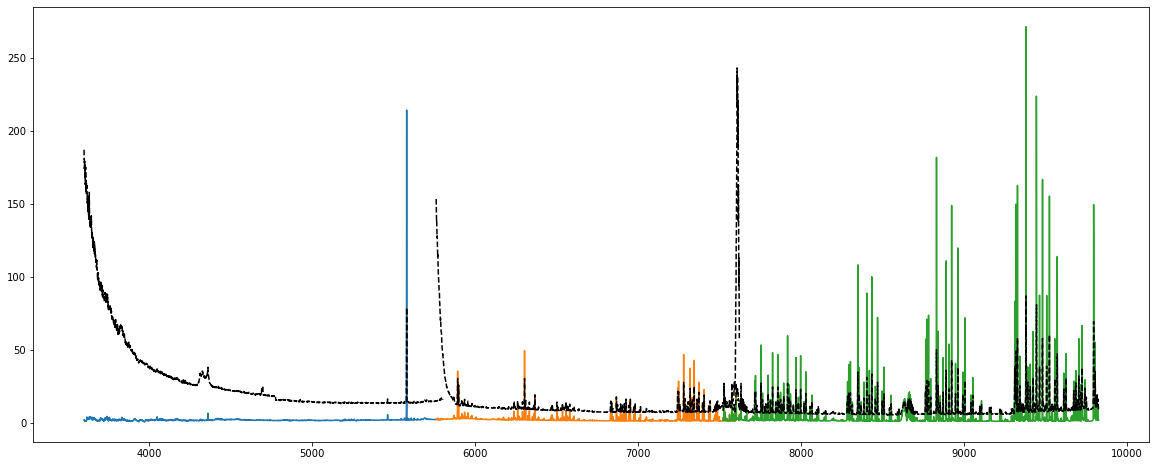

In [9]:
spectra_idx = 0

plt.figure(figsize=(20,8))
for camera in sky_flux:
    plt.plot(spectra.wave[camera],sky_flux[camera][spectra_idx])
    plt.plot(spectra.wave[camera],100 *(1/np.sqrt(spectra.ivar[camera][spectra_idx])), c="k", ls="--")
# plt.ylim(0,60)
plt.show()